# Exploración de datos inicial

Vamos a explorar los datos de los twits para entender de que trata el dataset, su estructura y como se comporta. Luego iremos iterando en el análisis para ir detectando patrones y _features_ interesantes mediante visualizaciones y estadísticas descriptivas.

Importamos las distintas librerías que vamos a utilizar para la exploración de datos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Constantes de colores para consistencia en las visualizaciones
COLOR_NO_DISASTER = '#3498db'  # Azul (coolwarm frío)
COLOR_DISASTER = '#e74c3c'     # Rojo (coolwarm cálido)
COLOR_GENERAL = '#95a5a6'      # Gris neutro

Importamos los datasets para su exploración inicial.

In [2]:
BASE_PATH = "../.data/raw/"

train_tweets = pd.read_csv(BASE_PATH + "train.csv")
test_tweets = pd.read_csv(BASE_PATH + "test.csv")

In [3]:
train_tweets.sample(n=5)

,id,keyword,location,text,target
5864,8377,ruin,NaN,Don't let a few assholes ruin your night,0
4379,6220,hijacker,worldwide,RT NotExplained: The only known image of infam...,0
1382,1992,bush%20fires,somewhere outside,Bush Fires are scary....even scarier when you ...,1
1110,1603,bombed,The land of New Jersey.,Shadowflame and the Wraith: Bombed http://t.co...,1
7411,10603,wounded,Worldwide - Global,Gunmen kill four in El Salvador bus attack: Su...,1


In [4]:
test_tweets.sample(n=5)

,id,keyword,location,text
1287,4229,drowned,California USA,Tried my 1st #beastburger by #beyondmeat. now...
1200,3942,devastated,"Toronto, Ontario",Devastated. Already missing my @coleenlisa. h...
1697,5737,forest%20fires,NaN,#Reuters #US Forest #Service says spending mor...
415,1342,blown%20up,"Toledo, OH",@KaylaG_Baby1 @jaykpurdy no shush. I'm gettin...
1319,4346,dust%20storm,San Francisco,A dust storm in Pheonix. http://t.co/AMgfOnzUSD


Agarro un sample aleatorio de ambos ya que los primeros y los últimos no tienen keywords ni locations por lo que no resultan representativos.

A simple vista tenemos:
- **tweet_id**: Identificador único del tweet.
- **keyword**: Palabra clave asociada al tweet (puede ser nula). Habría que entender si esta se determina automaticamente del contenido del tweet o si es asignada por un humano.
- **location**: Ubicación desde donde se envió el tweet (puede ser nula).
- **text**: Contenido del tweet en custión.

Y en el dataset de entrenamiento tenemos además:
- **target**: Etiqueta binaria que indica si el tweet está relacionado con un desastre real (1) o no (0).

## Análisis general del dataset

In [5]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_tweets.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


A simple vista, el dataset parece estar limpio y tiene un ~43% de tweets relacionados con desastres reales por lo que si bien no perfecto, está relativamente balanceado.

## Feature engineering

### Análisis de texto

Primero vamos analizar la composicisión del texto y vamos a sacar alguna features sencillas respecto a texto y particularmente a tweets:

* Longitud del tweet (número de caracteres)
* Número de palabras
* Número de hashtags
* Número de menciones
* Número de URLs
* Ratio de mayúsculas
* Ratio de signos de puntuación (.,!?"' etc)

Para ellos vamos a usar un approach naive basado en regex y funciones de string básicas.

In [7]:
tweets_with_features = train_tweets.copy()

tweets_with_features["text_length"] = tweets_with_features["text"].str.len()
tweets_with_features["word_count"] = tweets_with_features["text"].str.split().str.len()
tweets_with_features["hashtag_count"] = tweets_with_features["text"].str.count("#")
tweets_with_features["mention_count"] = tweets_with_features["text"].str.count("@")
tweets_with_features["url_count"] = tweets_with_features["text"].str.count("http")
tweets_with_features["uppercase_percentage"] = (
    tweets_with_features["text"].str.findall(r"[A-Z]").str.len()
    / tweets_with_features["text_length"]
)
tweets_with_features["punctuation_percentage"] = (
    tweets_with_features["text"].str.findall(r"[.,!?\"\'()]").str.len()
    / tweets_with_features["text_length"]
)

tweets_with_features.sample(n=5)

,id,keyword,location,text,target,text_length,word_count,hashtag_count,mention_count,url_count,uppercase_percentage,punctuation_percentage
5970,8523,screaming,NYC,@KamKasteIIano @BluntedJayt FUCKING SCREAMING !,0,47,5,0,2,0,0.468085,0.021277
6092,8699,sinking,Memphis,Nigga car sinking but he snapping it up for fo...,0,86,13,1,0,1,0.069767,0.023256
763,1104,blew%20up,NaN,I blew up snapchat for no reason ??,0,35,8,0,0,0,0.028571,0.057143
1828,2628,crashed,"Lincoln, NE",1 ÛÒ The bug that almost crashed the Euro - h...,1,67,11,0,0,1,0.104478,0.014925
1733,2497,collided,Mumbai,16 dead in Russia bus accident: At least 16 pe...,1,136,22,0,0,1,0.029412,0.029412


In [8]:
tweets_with_features.describe()

,id,target,text_length,word_count,hashtag_count,mention_count,url_count,uppercase_percentage,punctuation_percentage
count,7613.000000,7613.00000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,5441.934848,0.42966,101.037436,14.903586,0.446999,0.362406,0.620255,0.098497,0.027272
std,3137.116090,0.49506,33.781325,5.732604,1.099841,0.720097,0.664104,0.107203,0.030484
min,1.000000,0.00000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2734.000000,0.00000,78.000000,11.000000,0.000000,0.000000,0.000000,0.037500,0.010638
50%,5408.000000,0.00000,107.000000,15.000000,0.000000,0.000000,1.000000,0.073529,0.020619
75%,8146.000000,1.00000,133.000000,19.000000,0.000000,1.000000,1.000000,0.125000,0.034483
max,10873.000000,1.00000,157.000000,31.000000,13.000000,8.000000,4.000000,1.000000,0.500000


A partir de estás métricas podemos analizar su distribución a ver si es aleatoria o si hay patrones interesantes y agregar estos features por el target para ver si hay alguna correlación interesante.

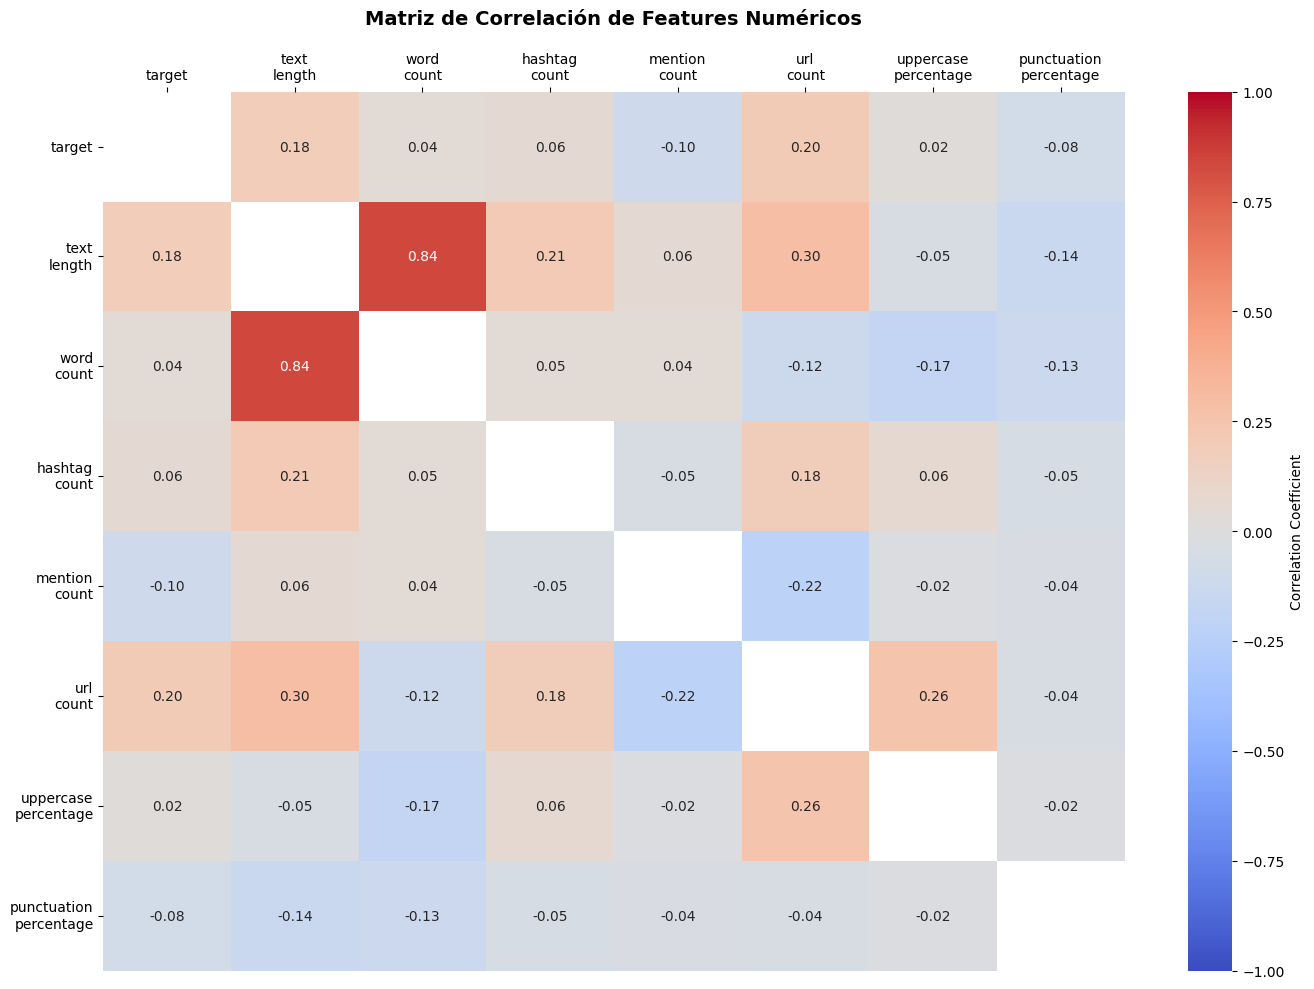

In [9]:
full_corr_matrix = tweets_with_features.corr(numeric_only=True)

full_corr_matrix = full_corr_matrix.drop('id', axis=0).drop('id', axis=1)

corr_matrix_no_diag = full_corr_matrix.copy()
np.fill_diagonal(corr_matrix_no_diag.values, np.nan)

fig, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(
    corr_matrix_no_diag,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Correlation Coefficient"},
)

# Mover etiquetas del eje x arriba y dividir por guiones bajos
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

xlabels = [label.get_text().replace('_', '\n') for label in ax.get_xticklabels()]
ylabels = [label.get_text().replace('_', '\n') for label in ax.get_yticklabels()]

ax.set_xticklabels(xlabels, rotation=0, ha='center')
ax.set_yticklabels(ylabels, rotation=0, ha='right')

plt.title("Matriz de Correlación de Features Numéricos", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

Obviamente ahí resaltan las features más obvias relacionadas con la longitud del texto y la aparición de elementos como palabras, hashtags, menciones, enlaces, etc.

Aún así hay cosas interesantes que se pueden observar, como que en los tweets relacionados con desastres reales tienden a tener más URLs y menos menciones dando alución que no es necesaria tanta interacción social en estos casos y que se comparten más links a noticias o información relevante.

Por otro lado otra correlación fuerte que aparece es la relación entre la longitud del tweet y el target lo cual también es lógico ya que en caso de tratarse de un desastre real, la gente tiende a explicar más la situación y a dar más detalles y en situaciones normales de tweets no relacionados con desastres, los mensajes tienden a ser más cortos y directos como un risa, una opinión o un comentario trivial.

Además de estar relaciones naives sería interesan analizar como se distribuyen estas features en función del target para ver si hay patrones interesantes. Para ello vamos a armar unos violin plots para cada feature donde en cada uno se vea la distribución original, la distribución para target=0 y la distribución para target=1. Esto nos permitirá ver outliers y como afectan otras métricas como la varianza y no solo analizar los casos promedios.

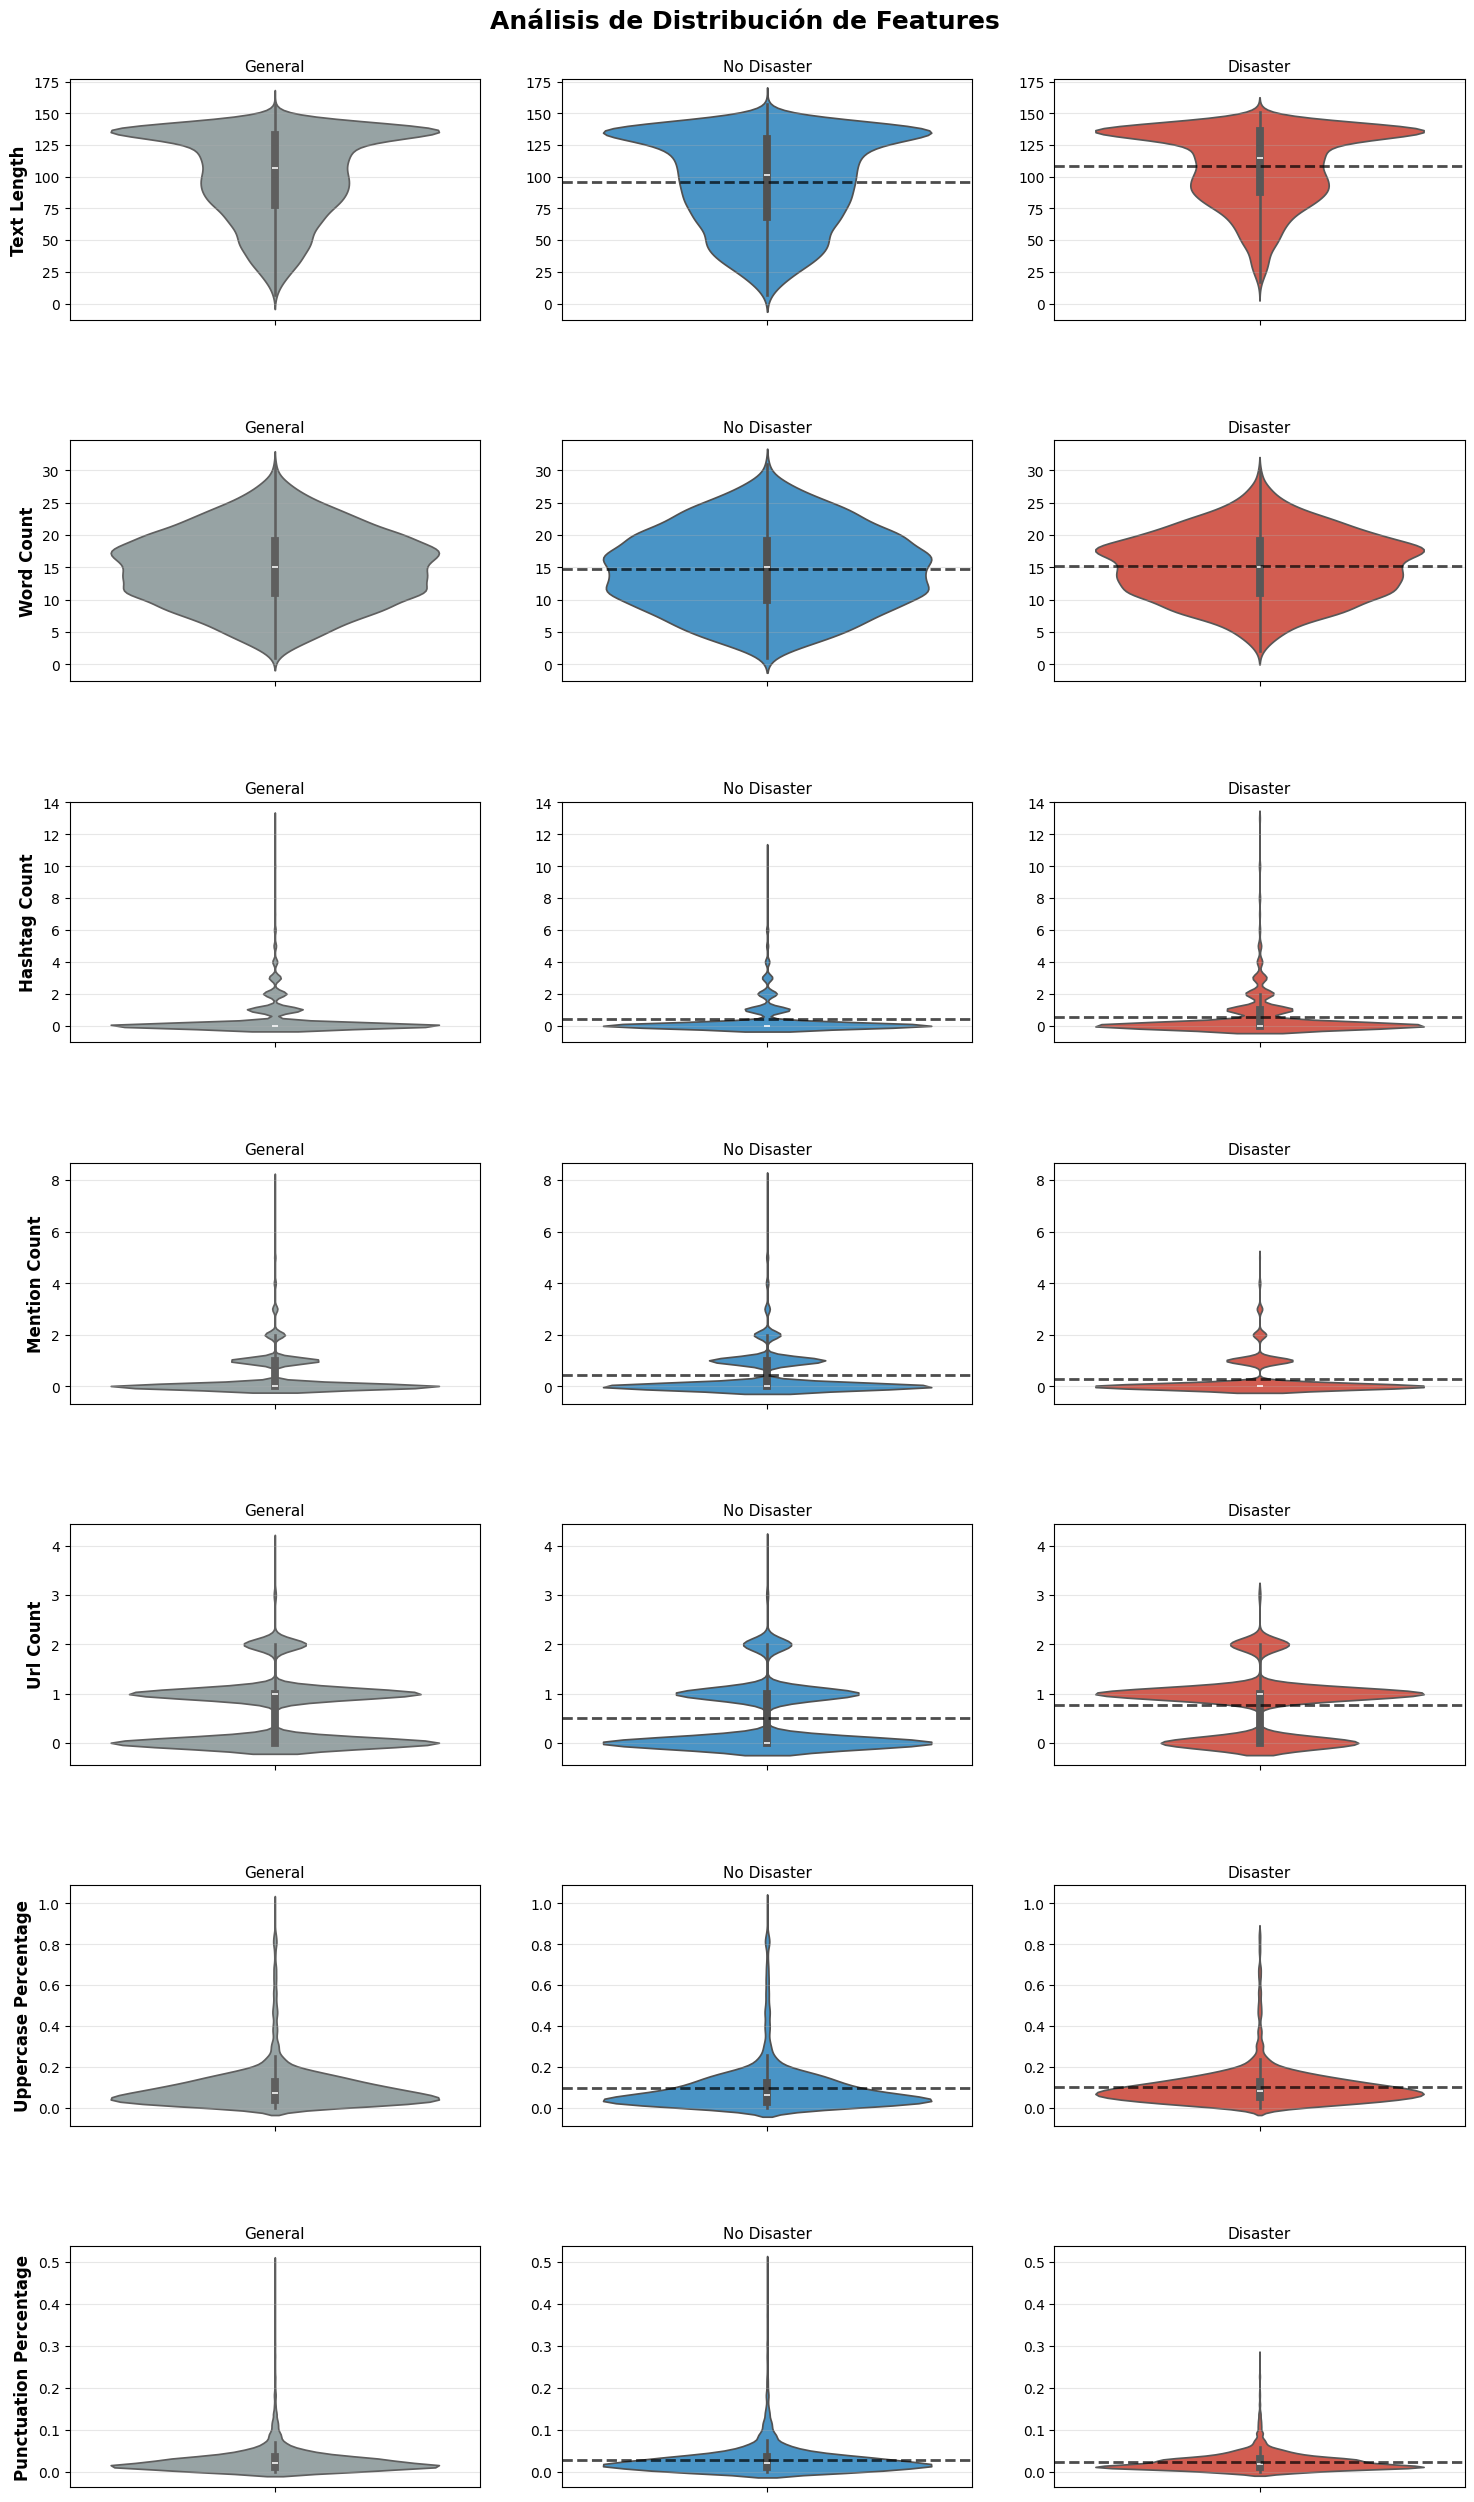

In [10]:
# Features a analizar
features = ['text_length', 'word_count', 'hashtag_count', 'mention_count', 
            'url_count', 'uppercase_percentage', 'punctuation_percentage']

# Crear figura con subplots compartiendo ejes
fig, axes = plt.subplots(len(features), 3, figsize=(18, 4*len(features)), 
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.2})

# Agregar título general
fig.text(0.5, 0.995, 'Análisis de Distribución de Features', 
         ha='center', va='top', fontsize=18, fontweight='bold')

# Para cada feature
for i, feature in enumerate(features):
    # Título grande de la fila (feature)
    feature_title = feature.replace("_", " ").title()
    
    # Columna 1: Distribución general
    sns.violinplot(
        data=tweets_with_features, 
        y=feature, 
        ax=axes[i, 0], 
        color=COLOR_GENERAL,
        inner='box'
    )
    axes[i, 0].set_title('General', fontsize=11)
    axes[i, 0].set_ylabel(feature_title, fontsize=12, fontweight='bold')
    axes[i, 0].grid(True, alpha=0.3, axis='y')
    
    # Columna 2: Target 0 (No Disaster)
    data_target_0 = tweets_with_features[tweets_with_features['target'] == 0]
    sns.violinplot(
        data=data_target_0, 
        y=feature, 
        ax=axes[i, 1], 
        color=COLOR_NO_DISASTER,
        inner='box'
    )
    axes[i, 1].set_title('No Disaster', fontsize=11)
    axes[i, 1].set_ylabel('')
    axes[i, 1].grid(True, alpha=0.3, axis='y')
    axes[i, 1].sharey(axes[i, 0])
    
    mean_0 = data_target_0[feature].mean()
    axes[i, 1].axhline(mean_0, color='black', linestyle='--', linewidth=2, alpha=0.7)
    
    # Columna 3: Target 1 (Disaster)
    data_target_1 = tweets_with_features[tweets_with_features['target'] == 1]
    sns.violinplot(
        data=data_target_1, 
        y=feature, 
        ax=axes[i, 2], 
        color=COLOR_DISASTER,
        inner='box'
    )
    axes[i, 2].set_title('Disaster', fontsize=11)
    axes[i, 2].set_ylabel('')
    axes[i, 2].grid(True, alpha=0.3, axis='y')
    axes[i, 2].sharey(axes[i, 0])
    
    mean_1 = data_target_1[feature].mean()
    axes[i, 2].axhline(mean_1, color='black', linestyle='--', linewidth=2, alpha=0.7)

plt.subplots_adjust(top=0.97)
plt.show()

Es muy interesante sobre todo el caso de URL count que se puede ver claramente como la mayoría de tweets tienen como mucho 2 URLs y que en el caso de 0 URLs hay una mayor tendencia por cuando no hay desastres y en el caso de 1 cuando sí los hay. Otro caso interesante es el de las puntaución que se ve que hay outliers con mucha puntuación y que corresponden a tweets sin desastres reales (muy probablemente spam o tweets con muchos signos de exclamación o interrogación).

Otras cosas interesantes que salen de los tweets aunque no tan relacionadas con el target son la cantidad de hashtags que unque lo más normal es que no haya ninguno, los mismos pueden crecer hasta 14 hashtags en un tweet probablemente que intentan maximizar su alcance. También es interesante ver la alta cantidad de tweets que hay con longitud entre 125 y 150 caracteres. Lo cual problemente se de al antiguo límite de 140 caracteres que tenían los tweets y que la gente aprovechaba al máximo. Esto también nos da un indica que el dataset es relativamente antiguo ya que este limite estuvo vigente hasta 2017.

### Análisis de Keywords

Las keywords son una feature categórica importante que puede tener mucha relación con el target. Vamos a comenzar con una limpieza básica de las keywords y luego analizar su frecuencia y su relación con el target.

#### Limpieza de Keywords

In [11]:
train_tweets['keyword_clean'] = train_tweets['keyword'].str.lower().str.replace('%20', ' ')

#### Estadísticas Básicas de Keywords

In [12]:
total_tweets = len(train_tweets)
tweets_with_keyword = train_tweets['keyword_clean'].notna().sum()
uniquie_keywords = train_tweets['keyword_clean'].nunique()

print(f"Total de tweets: {total_tweets:,}")
print(f"Tweets con keyword: {tweets_with_keyword:,} ({tweets_with_keyword/total_tweets*100:.1f}%)")
print(f"Keywords únicas: {uniquie_keywords}")
print(f"Promedio tweets/keyword: {tweets_with_keyword/uniquie_keywords:.1f}")

Total de tweets: 7,613
Tweets con keyword: 7,552 (99.2%)
Keywords únicas: 221
Promedio tweets/keyword: 34.2


Como vemos la mayoría de los tweets tienen una keyword asignada de las 221, por lo que sería sensato analizar su distribución y su relación con el target.

#### Top Keywords y Distribución por Target

In [13]:
keyword_stats = train_tweets.dropna(subset=['keyword_clean']).groupby('keyword_clean').agg({
    'target': ['sum', 'count', 'mean']
}).reset_index()
keyword_stats.columns = ['keyword', 'disaster_count', 'total_count', 'disaster_rate']

keyword_stats['no_disaster_pct'] = ((keyword_stats['total_count'] - keyword_stats['disaster_count']) / keyword_stats['total_count'] * 100).round(1)
keyword_stats['disaster_pct'] = (keyword_stats['disaster_count'] / keyword_stats['total_count'] * 100).round(1)

keyword_stats.describe()

,disaster_count,total_count,disaster_rate,no_disaster_pct,disaster_pct
count,221.000000,221.000000,221.000000,221.000000,221.000000
mean,14.610860,34.171946,0.424890,57.511312,42.488688
std,9.696891,4.786091,0.270708,27.074819,27.074819
min,0.000000,9.000000,0.000000,0.000000,0.000000
25%,6.000000,33.000000,0.181818,33.300000,18.200000
50%,13.000000,35.000000,0.378378,62.200000,37.800000
75%,22.000000,37.000000,0.666667,81.800000,66.700000
max,39.000000,45.000000,1.000000,100.000000,100.000000


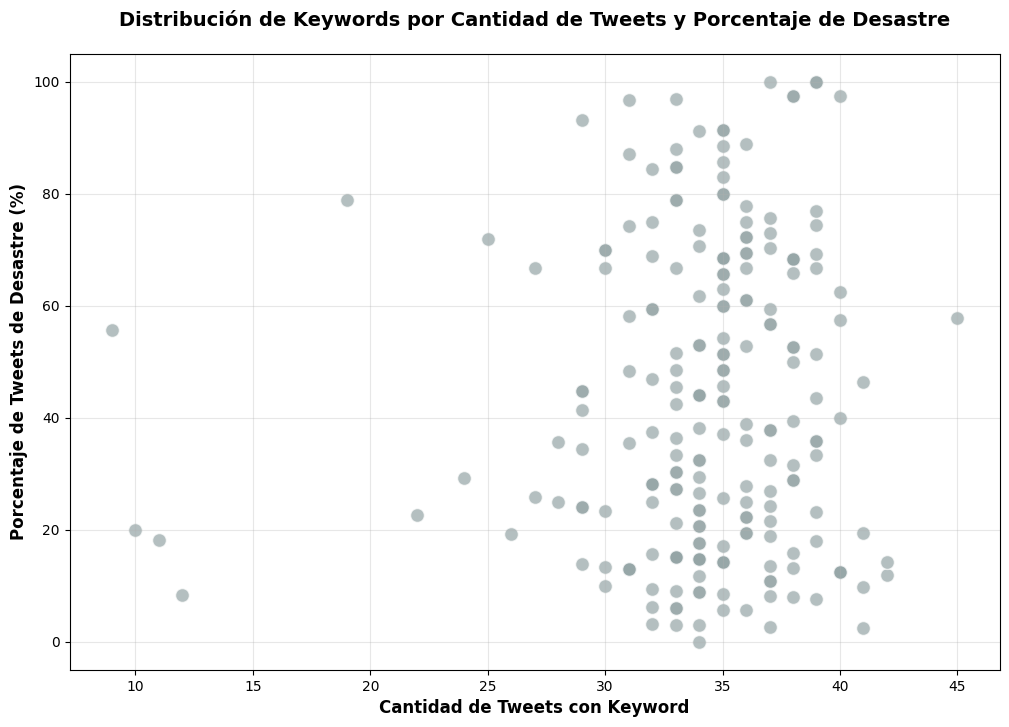

In [14]:
plt.figure(figsize=(12, 8))
plt.scatter(
    keyword_stats['total_count'],
    keyword_stats['disaster_pct'],
    s=100,
    alpha=0.7,
    edgecolors='w',
    color=COLOR_GENERAL
)

plt.xlabel('Cantidad de Tweets con Keyword', fontsize=12, fontweight='bold')
plt.ylabel('Porcentaje de Tweets de Desastre (%)', fontsize=12, fontweight='bold')
plt.title('Distribución de Keywords por Cantidad de Tweets y Porcentaje de Desastre', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.show()

Con esto, lo primero que vemos es que la mayoría de las keywords tienen una frecuencia similar (en el mismo orden de magnitud, de entre 20 y 45 apariciones). Aún así puede ser relevante identificar las keywords más frecuentes para ver su correlación con el target.

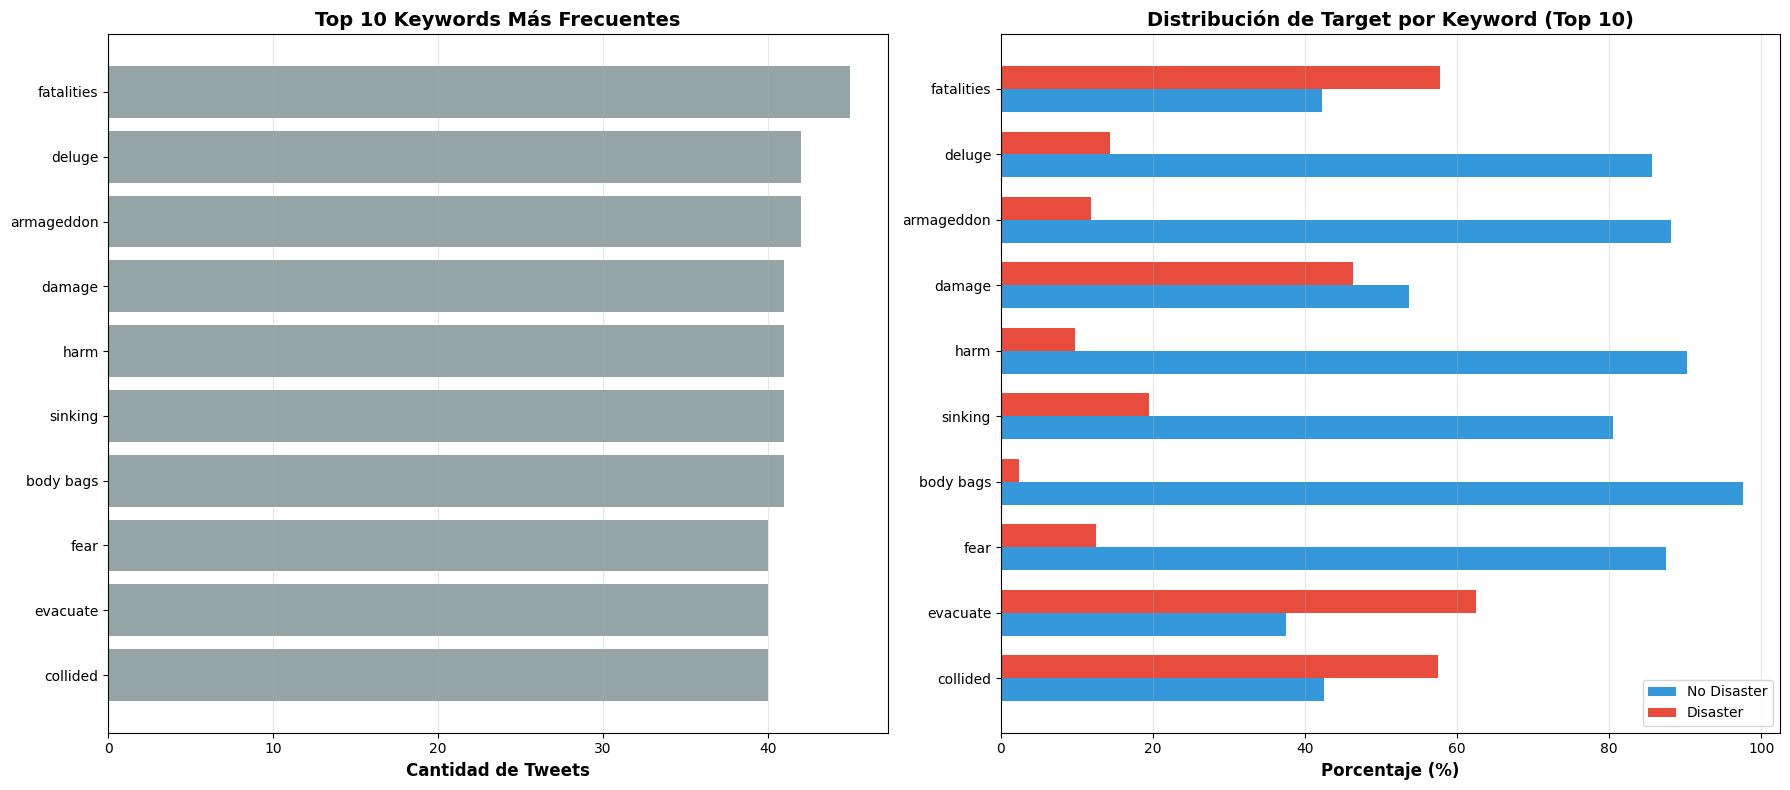

In [15]:
NUMBER_OF_KEYWORDS = 10

top_keywords_df = (
    keyword_stats.nlargest(NUMBER_OF_KEYWORDS, "total_count")
    .set_index("keyword")
    .sort_values("total_count", ascending=True)
)
top_keywords = top_keywords_df.index

# Visualización: Top Keywords y su distribución por target
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico 1: Top Keywords más frecuentes
axes[0].barh(range(len(top_keywords)), top_keywords_df["total_count"].values, color=COLOR_GENERAL)
axes[0].set_yticks(range(len(top_keywords)))
axes[0].set_yticklabels(top_keywords)
axes[0].set_xlabel("Cantidad de Tweets", fontsize=12, fontweight="bold")
axes[0].set_title(
    f"Top {NUMBER_OF_KEYWORDS} Keywords Más Frecuentes", fontsize=14, fontweight="bold"
)
axes[0].grid(True, alpha=0.3, axis="x")

# Gráfico 2: Distribución por target de top keywords
x = np.arange(len(top_keywords))
width = 0.35

bars1 = axes[1].barh(
    x - width / 2,
    top_keywords_df["no_disaster_pct"],
    width,
    label="No Disaster",
    color=COLOR_NO_DISASTER,
)
bars2 = axes[1].barh(
    x + width / 2,
    top_keywords_df["disaster_pct"],
    width,
    label="Disaster",
    color=COLOR_DISASTER,
)

axes[1].set_yticks(x)
axes[1].set_yticklabels(top_keywords)
axes[1].set_xlabel("Porcentaje (%)", fontsize=12, fontweight="bold")
axes[1].set_title(
    f"Distribución de Target por Keyword (Top {NUMBER_OF_KEYWORDS})",
    fontsize=14,
    fontweight="bold",
)
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

Acá vemos cuáles son las keywords más frecuentes y cómo cada una tiene una tendencia que no tiene nada que ver con su frecuencia. El scatter plot ya nos daba una idea de esto, pero está bueno destacar que una keyword popular no necesariamente nos dice algo sobre su relación con desastres reales. Lo interesante es que muchas keywords indican claramente si un tweet está relacionado con un desastre real o no.

**Ejemplos de keywords:**

- **Ambiguas:** "facilities" o "damage" tienen un reparto 40/60 entre tweets de desastre y no desastre.
- **Claramente no desastre:** "deluge", "armageddon" y "body bags" dejan clarísimo que el tweet NO está relacionado con un desastre real.
- **Más ligadas a desastre:** "evacuate" tiende a estar asociada con desastres reales, aunque no tan claramente como las anteriores.

Vamos a explorar cuáles son las keywords que más claramente distinguen si un tweet es sobre un desastre real o no. Si mantienen este patrón en una buena cantidad de tweets, podrían ser un indicador fuerte para predecir el target.

#### Keywords Más Concluyentes

Vamos a identificar qué keywords están más asociadas con desastres reales vs no reales independientemente de su frecuencia.

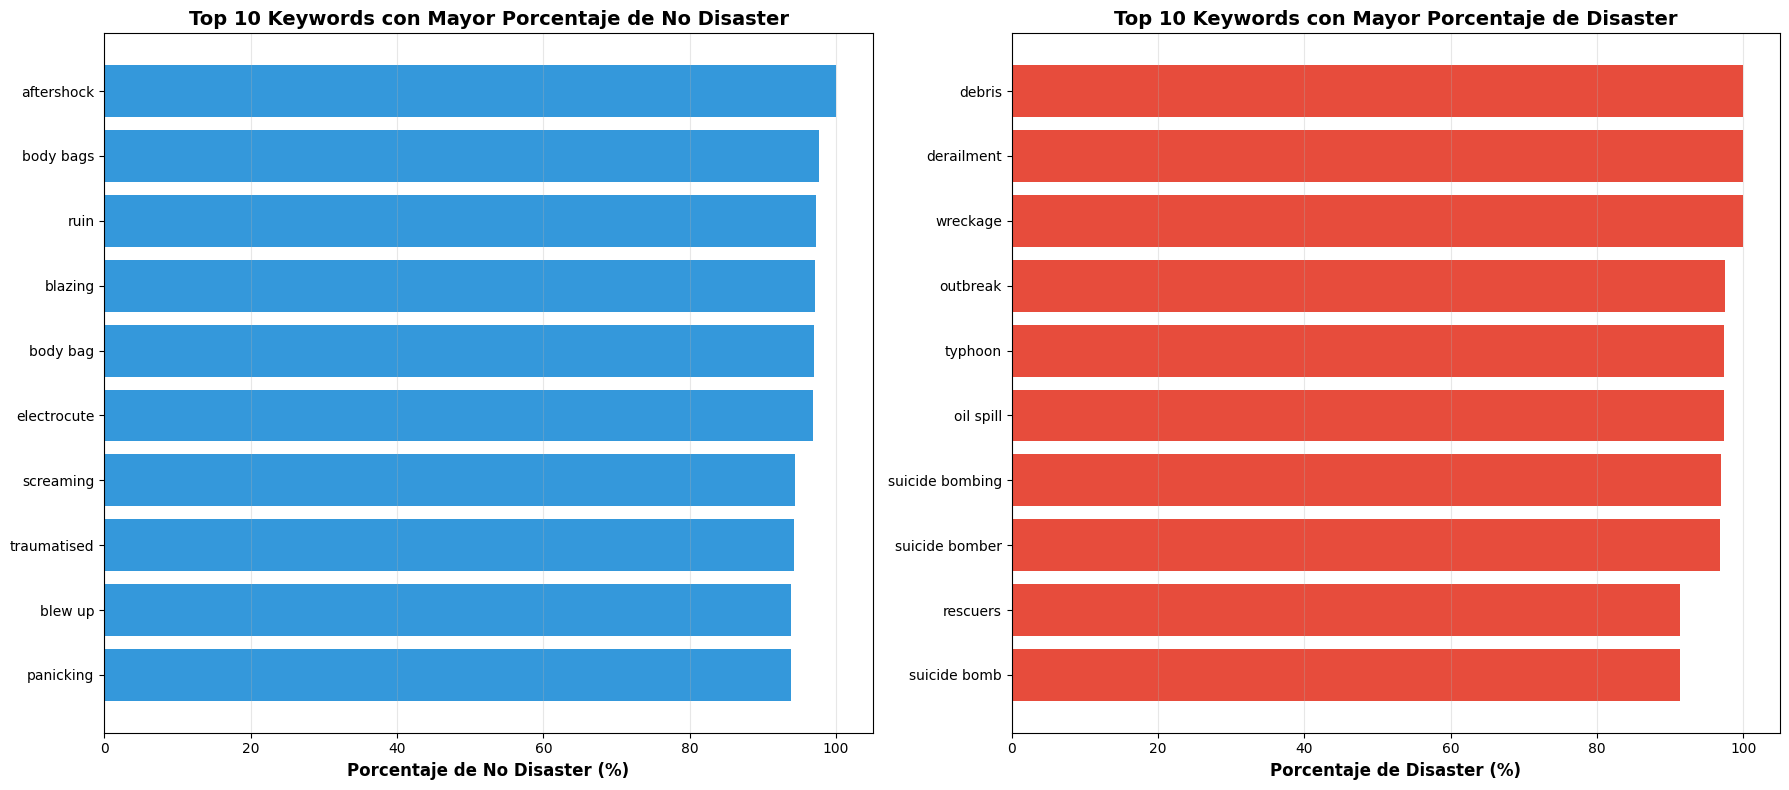

In [16]:
MINIMUM_TWEETS = 30
NUMBER_OF_KEYWORDS = 10

keyword_stats_filtered = keyword_stats[keyword_stats['total_count'] >= MINIMUM_TWEETS]
low_disaster = keyword_stats_filtered.nlargest(NUMBER_OF_KEYWORDS, 'no_disaster_pct').sort_values('no_disaster_pct')
high_disaster = keyword_stats_filtered.nlargest(NUMBER_OF_KEYWORDS, 'disaster_pct').sort_values('disaster_pct')

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico 1: Keywords con mayor porcentaje de No Disaster
axes[0].barh(
    low_disaster['keyword'],
    low_disaster['no_disaster_pct'],
    color=COLOR_NO_DISASTER
)
axes[0].set_xlabel('Porcentaje de No Disaster (%)', fontsize=12, fontweight='bold')
axes[0].set_title(
    f'Top {NUMBER_OF_KEYWORDS} Keywords con Mayor Porcentaje de No Disaster',
    fontsize=14, fontweight='bold'
)
axes[0].grid(True, alpha=0.3, axis='x')

# Gráfico 2: Keywords con mayor porcentaje de Disaster
axes[1].barh(
    high_disaster['keyword'],
    high_disaster['disaster_pct'],
    color=COLOR_DISASTER
)
axes[1].set_xlabel('Porcentaje de Disaster (%)', fontsize=12, fontweight='bold')
axes[1].set_title(
    f'Top {NUMBER_OF_KEYWORDS} Keywords con Mayor Porcentaje de Disaster',
    fontsize=14, fontweight='bold'
)
axes[1].grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

Vemos claramente que hay keywords muy concluyentes respecto al target, tanto para tweets de desastre como para no desastre, tenemos al menos 10 keywords que superan el 90% de asociación con su respectivo target y que tienen al menos 30 tweets asociados.

Aunque esto pueda resultar muy bueno a nivel predictivo, tenemos que tener cuidado de no depender únicamente de estas keywords ya que podrían hacer overfitting al modelo y no generalizar bien a nuevos datos. Además sería un error asumir que solo por tener estas keywords ya podemos predecir el target sin analizar el resto del contenido del tweet ya que tranquilamente el keyword podría estar siendo generado a parir del contenido del tweet y no dar realmente información adicional incluso descartando información relevante para concluir cuando la keyword es ambigua.

De todos modos es información útil para tener en cuenta a la hora de modelar.

## Análisis de Location

Las ubicaciones también pueden tener relación con el tipo de tweet. Vamos a hacer un análisis aislado de las ubicaciones para intentar de identificar patrones ya que un tweet puede tener una intención diferente dependiendo de la ubicación desde donde se envía.

Primero calcularemos las estadísticas básicas de las locations para ver su distribución y frecuencia y luego analizaremos su relación con el target.

In [17]:
total_tweets = len(train_tweets)
tweets_with_location = train_tweets['location'].notna().sum()
unique_locations = train_tweets['location'].nunique()

print(f"Total de tweets: {total_tweets:,}")
print(f"Tweets con location: {tweets_with_location:,} ({tweets_with_location/total_tweets*100:.1f}%)")
print(f"Locations únicas: {unique_locations}")
print(f"Promedio tweets/location: {tweets_with_location/unique_locations:.1f}")

Total de tweets: 7,613
Tweets con location: 5,080 (66.7%)
Locations únicas: 3341
Promedio tweets/location: 1.5


In [18]:
location_stats = train_tweets.dropna(subset=['location']).groupby('location').agg({
    'target': ['sum', 'count', 'mean']
}).reset_index()
location_stats.columns = ['location', 'disaster_count', 'total_count', 'disaster_rate']

location_stats['no_disaster_pct'] = ((location_stats['total_count'] - location_stats['disaster_count']) / location_stats['total_count'] * 100).round(1)
location_stats['disaster_pct'] = (location_stats['disaster_count'] / location_stats['total_count'] * 100).round(1)

location_stats.describe()

,disaster_count,total_count,disaster_rate,no_disaster_pct,disaster_pct
count,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000
mean,0.657288,1.520503,0.405421,59.457947,40.542053
std,1.743988,3.022364,0.468799,46.880078,46.880078
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,100.000000,0.000000
75%,1.000000,1.000000,1.000000,100.000000,100.000000
max,67.000000,104.000000,1.000000,100.000000,100.000000


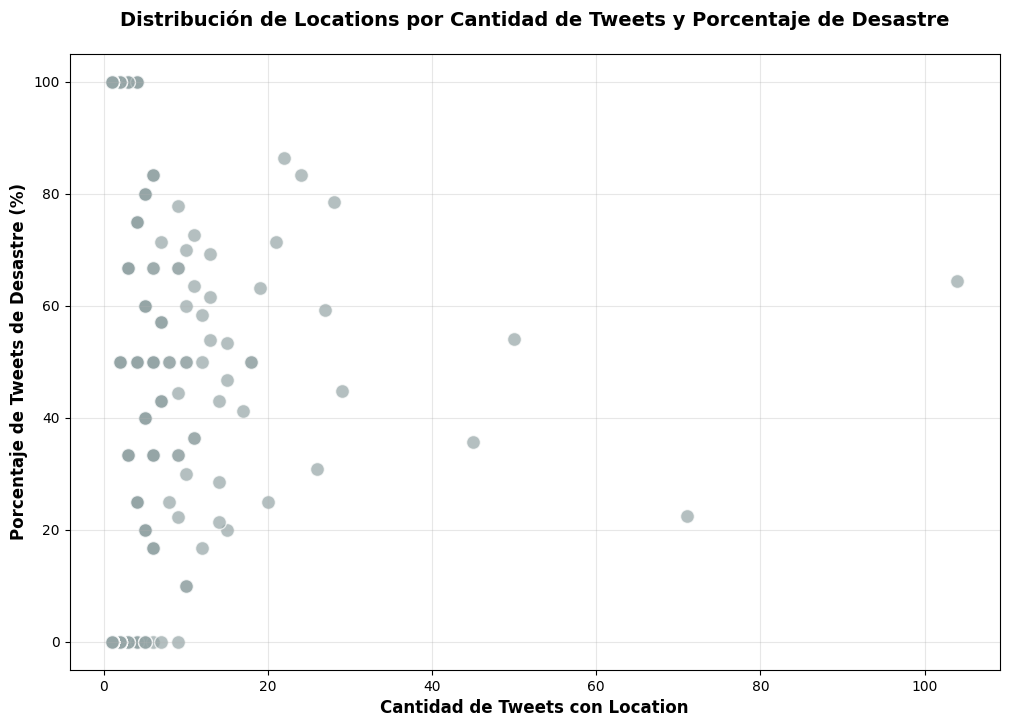

In [19]:
plt.figure(figsize=(12, 8))
plt.scatter(
    location_stats['total_count'],
    location_stats['disaster_pct'],
    s=100,
    alpha=0.7,
    edgecolors='w',
    color=COLOR_GENERAL
)
plt.xlabel('Cantidad de Tweets con Location', fontsize=12, fontweight='bold')
plt.ylabel('Porcentaje de Tweets de Desastre (%)', fontsize=12, fontweight='bold')
plt.title('Distribución de Locations por Cantidad de Tweets y Porcentaje de Desastre', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.show()

A diferencia de las keywords las ubicaciones son una variable categorica con demasiadas opciones, por lo que va a ser dificil analizar tendencias de la mayoría ya que hasta un 75% de las ubicaciones tienen 1 solo tweet asociado.

Por lo que vamos a filtrar por aquellas que tienen al menos 30 tweets y recién ahí analizar tendencias.

In [20]:
MINIMUM_TWEETS = 30

location_stats_filtered = location_stats[
    location_stats["total_count"] >= MINIMUM_TWEETS
].sort_values("total_count", ascending=True)

print(
    f"Total de locations después de filtrar por al menos {MINIMUM_TWEETS} tweets: {len(location_stats_filtered):,}"
)

Total de locations después de filtrar por al menos 30 tweets: 4


Solo tenemos 4 ubicaciones que cumplen este criterio, podemos hacer un pequeño analisis de como se comportan.

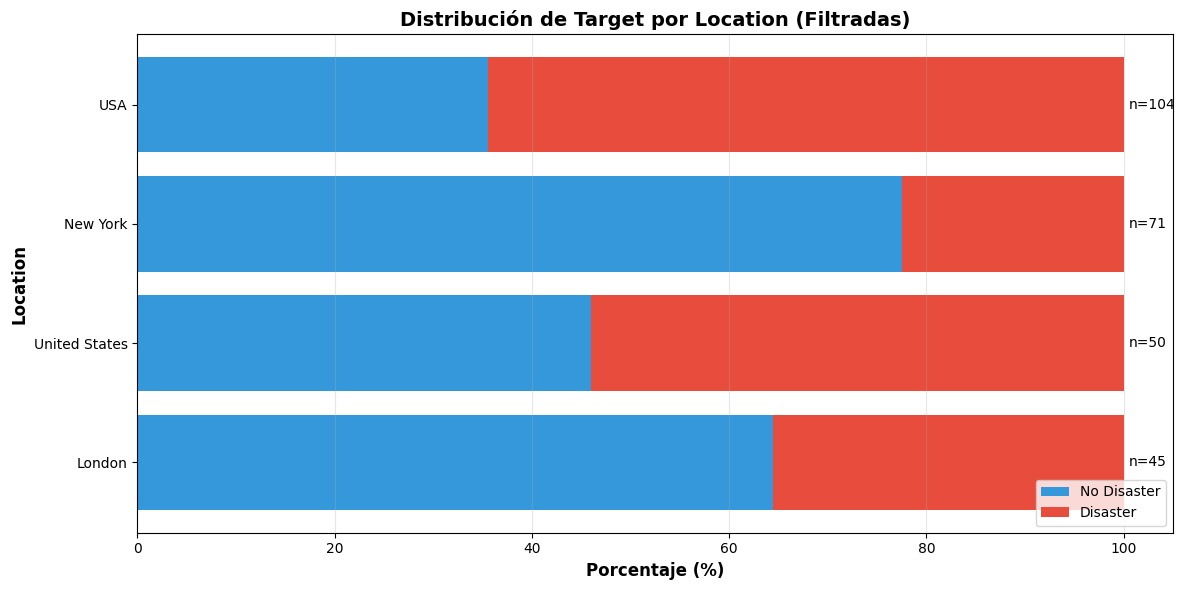

In [21]:
# Visualización de locations filtradas por target (stacked bar horizontal)
fig, ax = plt.subplots(figsize=(12, 6))

# Barras apiladas horizontales
ax.barh(location_stats_filtered['location'], location_stats_filtered['no_disaster_pct'], color=COLOR_NO_DISASTER, label='No Disaster')
ax.barh(location_stats_filtered['location'], location_stats_filtered['disaster_pct'], left=location_stats_filtered['no_disaster_pct'], color=COLOR_DISASTER, label='Disaster')

ax.set_xlabel('Porcentaje (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Location', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Target por Location (Filtradas)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

# Agregar anotaciones con el total de tweets al final de cada barra
for i, (loc, no_dis_pct, dis_pct, total) in enumerate(zip(location_stats_filtered['location'], location_stats_filtered['no_disaster_pct'], location_stats_filtered['disaster_pct'], location_stats_filtered['total_count'])):
    ax.text(no_dis_pct + dis_pct + 0.5, i, f'n={total}', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

Poco se puede concluir de está métrica lo que está claro es que Estados Unidos parece ser la ubicación dominante en cuanto a la fuente de tweets ya que ocupa los 3 primeros puestos por lo que todo el dataset puede estar muy sesgado hacia tweets provenientes de ese país. Eso puede ser por los tweets extraidos o porque la mayoría de usuarios de twitter están en esa región.

## Lematización

La lematización es el proceso de reducir las palabras a su forma base o raíz, conocida como lema. Esto nos permite entender mejor el significado de las palabras y nos ayuda a encontrar relaciones más profundas en el texto al agrupar diferentes formas de una palabra bajo un mismo lema. Por ejemplo, las palabras "corriendo", "corrí" y "correrá" se lematizan a "correr". Podemos aplicar esta idea a nuestra análisis sobre el texto de los tweets para buscar patrones de lemas que puedan estar relacionados con desastres reales o no.

Vamos a usar `spacy` para hacer la lematización del texto y de las keywords, `emoji` para manejar los emojis. Por último vamos a usar el modelo de lenguaje en inglés de `spacy` para hacer la lematización correctamente teniendo en cuenta el contexto de las palabras `en_core_web_sm`.

In [22]:
import emoji
import spacy
import re


model = spacy.load("en_core_web_sm", disable=["parser", "ner"]) # Cargar solo el componente de lematización
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [23]:
def clean_tweet(text):
    text = text.lower()                             # todo en minúsculas
    text = re.sub(r'@\w+', '', text)                # menciones limpiadas
    text = re.sub(r'http\S+|www.\S+', '', text)     # limpiamos los links
    text = emoji.replace_emoji(text, replace=' ')   # reemplazo emojis por espacio
    text = re.sub(r'[^\w\s]', ' ', text)            # saco simbolos especiales
    text = re.sub(r'\s+', ' ', text).strip()        # quito espacios extras
    return text

def lemma_filter(token):
    return token.lemma_ not in stop_words and len(token.lemma_) > 1 # vamos a filtrar stopwords y lemas de longitud 1 (letras sueltas)

def lemmatize_text(text):
    cleaned_text = clean_tweet(text)
    doc = model(cleaned_text)

    return ' '.join([token.lemma_ for token in doc if lemma_filter(token)])

In [24]:
train_tweets['text_lemmatized'] = train_tweets['text'].apply(lemmatize_text)
train_tweets[['text', 'text_lemmatized']].sample(n=5)

,text,text_lemmatized
7177,70 years ago today the U.S. dropped a nuclear...,70 year ago today drop nuclear weapon japan ar...
2029,@CarsonRex @SpaceAngelSeven Check out this #ro...,check rockin preview danger zone come soon art...
6893,@malabamiandsons she's proper traumatised that...,proper traumatise pepper dead wait face
3940,survived the plague\nfloated the flood\njust p...,survive plague float flood peek head mud immun...
581,FedEx to stop transporting bioterror germs aft...,fedex stop transport bioterror germ lab mishap...


Con esto ahora podemos hacer un word count sobre los lemas y ver cuáles son los lemas más frecuentes en los tweets relacionados con desastres reales y no reales.

In [25]:
word_df = train_tweets.assign(words=train_tweets['text_lemmatized'].str.split()).explode('words')

word_stats = word_df.groupby('words').agg({
    'target': ['sum', 'count']
}).reset_index()
word_stats.columns = ['word', 'disaster_count', 'total_count']

word_stats['disaster_rate'] = word_stats['disaster_count'] / word_stats['total_count']
word_stats['no_disaster_count'] = word_stats['total_count'] - word_stats['disaster_count']

word_stats['no_disaster_pct'] = (word_stats['no_disaster_count'] / word_stats['total_count'] * 100).round(1)
word_stats['disaster_pct'] = (word_stats['disaster_count'] / word_stats['total_count'] * 100).round(1)

word_stats = word_stats.sort_values('total_count', ascending=False).reset_index(drop=True)

word_stats.sample(n=5)

,word,disaster_count,total_count,disaster_rate,no_disaster_count,no_disaster_pct,disaster_pct
3105,beg,1,3,0.333333,2,66.7,33.3
1301,easy,0,9,0.000000,9,100.0,0.0
826,threaten,16,16,1.000000,0,0.0,100.0
4032,mil,0,2,0.000000,2,100.0,0.0
4796,gordon,1,2,0.500000,1,50.0,50.0


In [26]:
word_stats.describe()

,disaster_count,total_count,disaster_rate,no_disaster_count,no_disaster_pct,disaster_pct
count,12356.000000,12356.000000,12356.000000,12356.000000,12356.000000,12356.000000
mean,2.390499,5.067659,0.410071,2.677161,58.993210,41.006790
std,7.952748,14.165226,0.433096,7.988119,43.309823,43.309823
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.250000,1.000000,75.000000,25.000000
75%,1.000000,3.000000,1.000000,2.000000,100.000000,100.000000
max,273.000000,395.000000,1.000000,294.000000,100.000000,100.000000


Veamos entonces cuales son las palabras más populares y las que más relación tienen con desastres reales y no reales.

#### Top Lemas y Distribución por Target

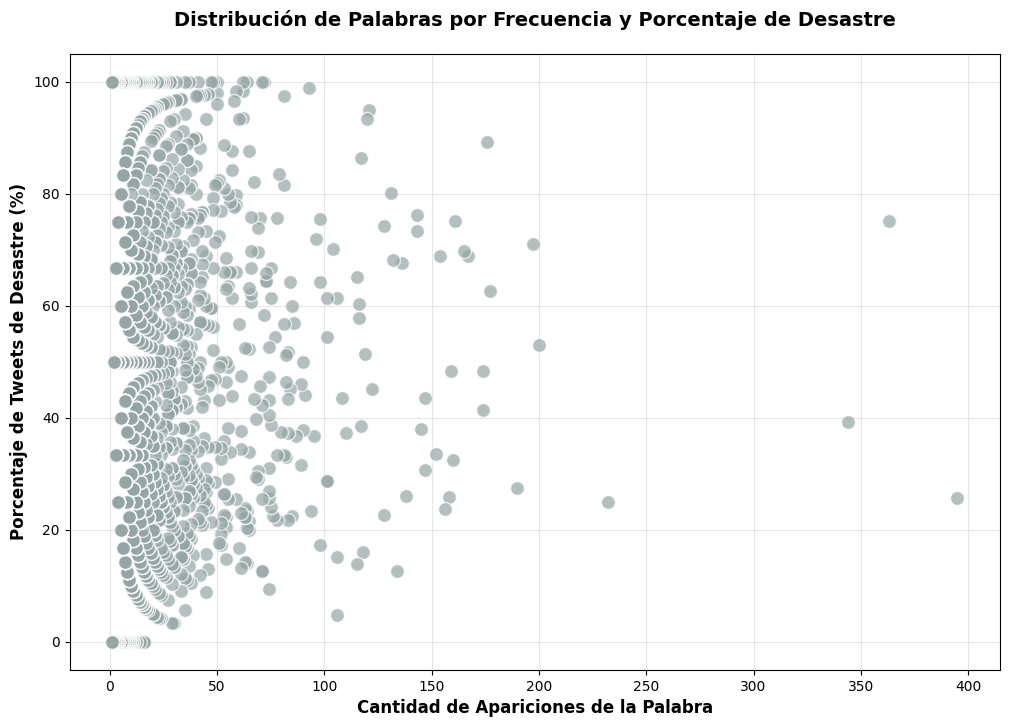

In [27]:
plt.figure(figsize=(12, 8))
plt.scatter(
    word_stats['total_count'],
    word_stats['disaster_pct'],
    s=100,
    alpha=0.7,
    edgecolors='w',
    color=COLOR_GENERAL
)

plt.xlabel('Cantidad de Apariciones de la Palabra', fontsize=12, fontweight='bold')
plt.ylabel('Porcentaje de Tweets de Desastre (%)', fontsize=12, fontweight='bold')
plt.title('Distribución de Palabras por Frecuencia y Porcentaje de Desastre', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.show()

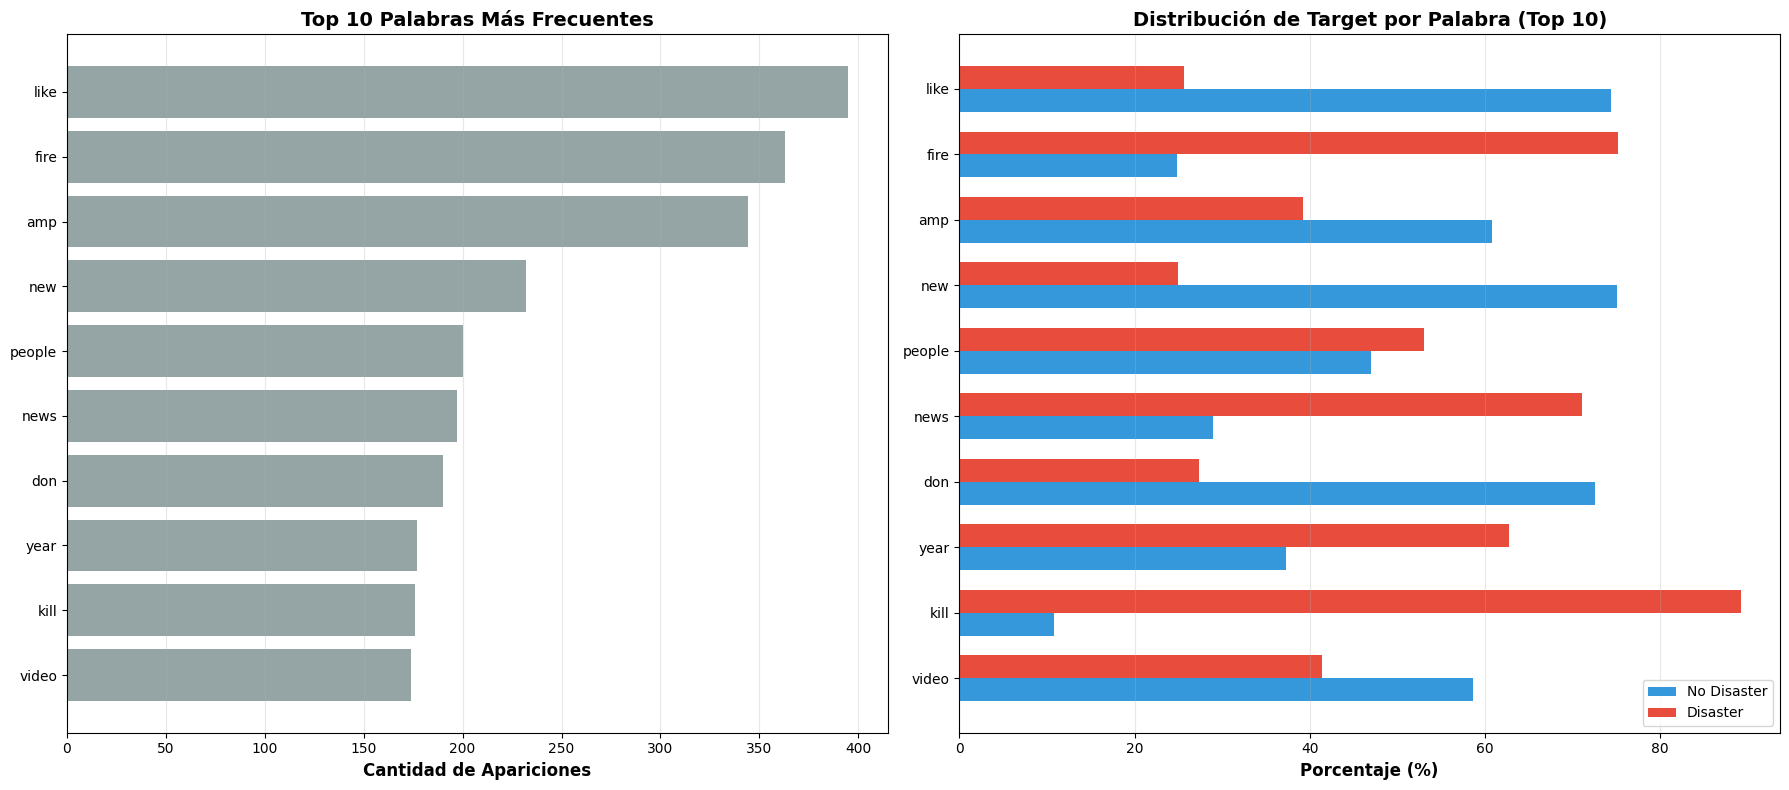

In [28]:
NUMBER_OF_WORDS = 10

top_words_df = (
    word_stats.nlargest(NUMBER_OF_WORDS, "total_count")
    .set_index("word")
    .sort_values("total_count", ascending=True)
)
top_words = top_words_df.index

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico 1: Top Words más frecuentes
axes[0].barh(range(len(top_words)), top_words_df["total_count"].values, color=COLOR_GENERAL)
axes[0].set_yticks(range(len(top_words)))
axes[0].set_yticklabels(top_words)
axes[0].set_xlabel("Cantidad de Apariciones", fontsize=12, fontweight="bold")
axes[0].set_title(
    f"Top {NUMBER_OF_WORDS} Palabras Más Frecuentes", fontsize=14, fontweight="bold"
)
axes[0].grid(True, alpha=0.3, axis="x")

# Gráfico 2: Distribución por target de top words
x = np.arange(len(top_words))
width = 0.35

bars1 = axes[1].barh(
    x - width / 2,
    top_words_df["no_disaster_pct"],
    width,
    label="No Disaster",
    color=COLOR_NO_DISASTER,
)
bars2 = axes[1].barh(
    x + width / 2,
    top_words_df["disaster_pct"],
    width,
    label="Disaster",
    color=COLOR_DISASTER,
)

axes[1].set_yticks(x)
axes[1].set_yticklabels(top_words)
axes[1].set_xlabel("Porcentaje (%)", fontsize=12, fontweight="bold")
axes[1].set_title(
    f"Distribución de Target por Palabra (Top {NUMBER_OF_WORDS})",
    fontsize=14,
    fontweight="bold",
)
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

Muy parecido que con las keywords, vemos que las palabras más frecuentes no necesariamente son las más relacionadas con desastres reales o no reales. Lo que si vemos es que la presencia de ciertos lemas como "fire", "kill", "news" están fuertemente asociadas con desastres reales, mientras que lemas como "like" o "new" están más ligadas a tweets no relacionados con desastres. Vease el la diferencia entre "news" y "new".

#### Lemas Más Concluyentes

Vamos a identificar qué palabras están más asociadas con desastres reales vs no reales independientemente de su frecuencia.

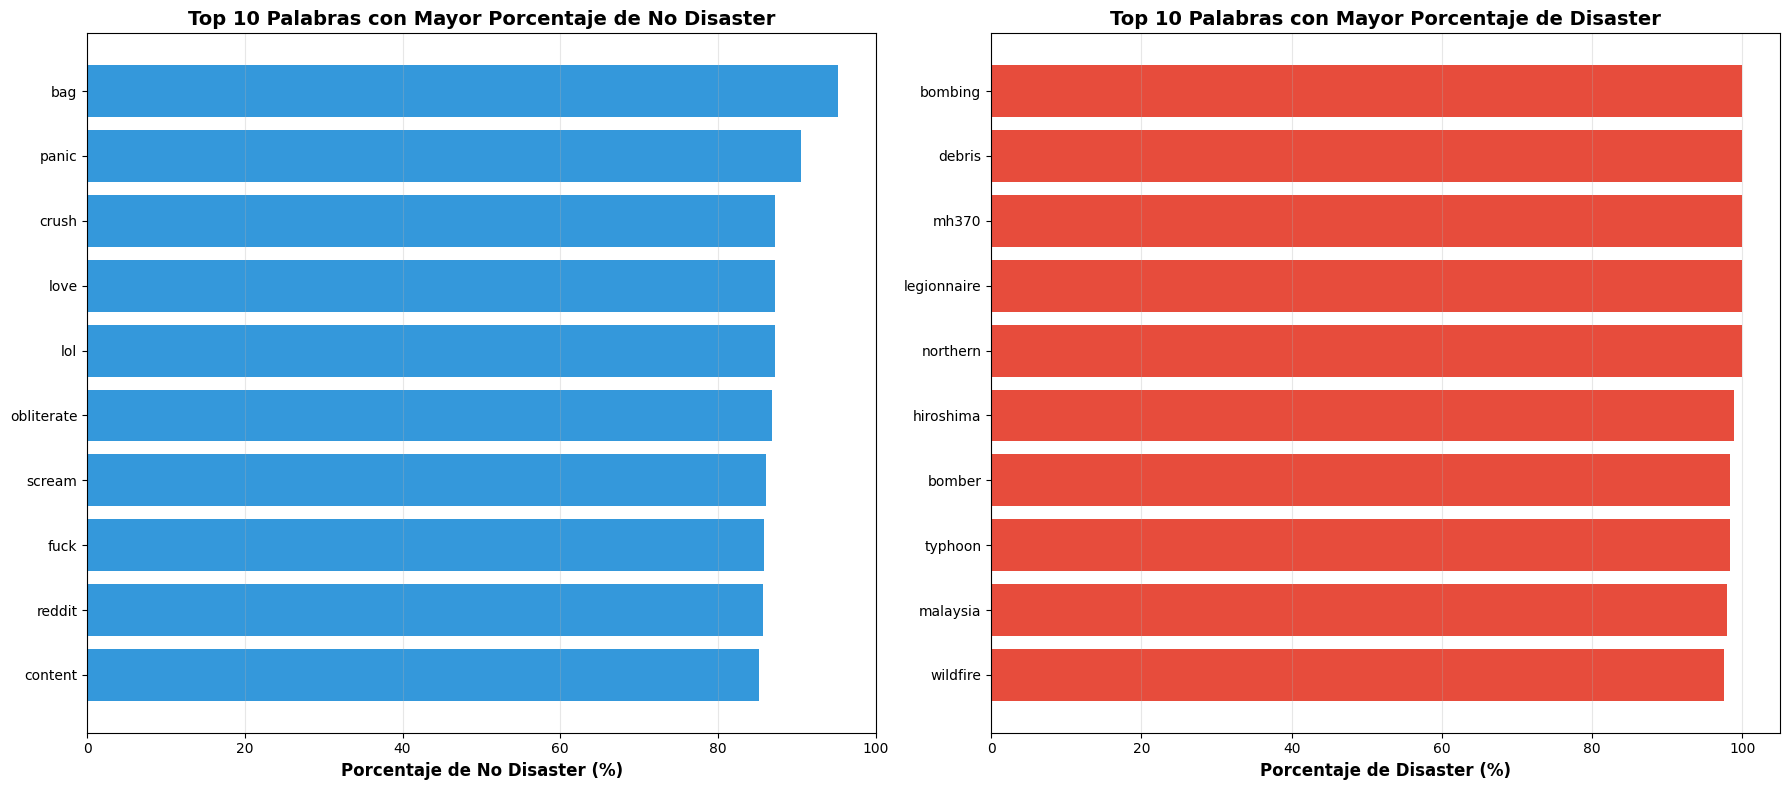

In [29]:
MINIMUM_APPEARANCES = 50
NUMBER_OF_WORDS = 10

word_stats_filtered = word_stats[word_stats['total_count'] >= MINIMUM_APPEARANCES]
low_disaster = word_stats_filtered.nlargest(NUMBER_OF_WORDS, 'no_disaster_pct').sort_values('no_disaster_pct')
high_disaster = word_stats_filtered.nlargest(NUMBER_OF_WORDS, 'disaster_pct').sort_values('disaster_pct')

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico 1: Palabras con mayor porcentaje de No Disaster
axes[0].barh(
    low_disaster['word'],
    low_disaster['no_disaster_pct'],
    color=COLOR_NO_DISASTER
)
axes[0].set_xlabel('Porcentaje de No Disaster (%)', fontsize=12, fontweight='bold')
axes[0].set_title(
    f'Top {NUMBER_OF_WORDS} Palabras con Mayor Porcentaje de No Disaster',
    fontsize=14, fontweight='bold'
)
axes[0].grid(True, alpha=0.3, axis='x')

# Gráfico 2: Palabras con mayor porcentaje de Disaster
axes[1].barh(
    high_disaster['word'],
    high_disaster['disaster_pct'],
    color=COLOR_DISASTER
)
axes[1].set_xlabel('Porcentaje de Disaster (%)', fontsize=12, fontweight='bold')
axes[1].set_title(
    f'Top {NUMBER_OF_WORDS} Palabras con Mayor Porcentaje de Disaster',
    fontsize=14, fontweight='bold'
)
axes[1].grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

Vemos claramente como palabras que son de la jerga común de twitter, como "love", "lol", "reddit" o "f*ck" están fuertemente asociadas a tweets no relacionados con desastres reales. Por otro lado palabras como "bombing", "debris" o "wildfire" están muy ligadas a desastres reales. Vemos que hay palabras de casos más concretos como "mh37" un vuelo desaparecido, o "malaysia" probablemente relacionado con desastres aéreos.

Esto nos lleva a pensar que el análisis de lemas puede ser una herramienta poderosa para identificar patrones en los tweets y ayudar a predecir si un tweet está relacionado con un desastre real o no. Al igual que con las keywords, debemos tener cuidado de no depender únicamente de estas palabras concluyentes para evitar overfitting y asegurar que nuestro modelo generalice bien a nuevos datos.

#### Word Cloud de Palabras Lematizadas

Como corolario vamos a realizar una visualización que nos permita ver en forma ilustrativa cuales son las palabras más frecuentes y su relación con desastres reales o no. Vamos a hacer un word cloud con forma del viejo logo de twitter (actualmente X) donde el tamaño de las palabras represente su frecuencia total, y el color indique si están más asociadas con desastres (rojo) o no desastres (azul).

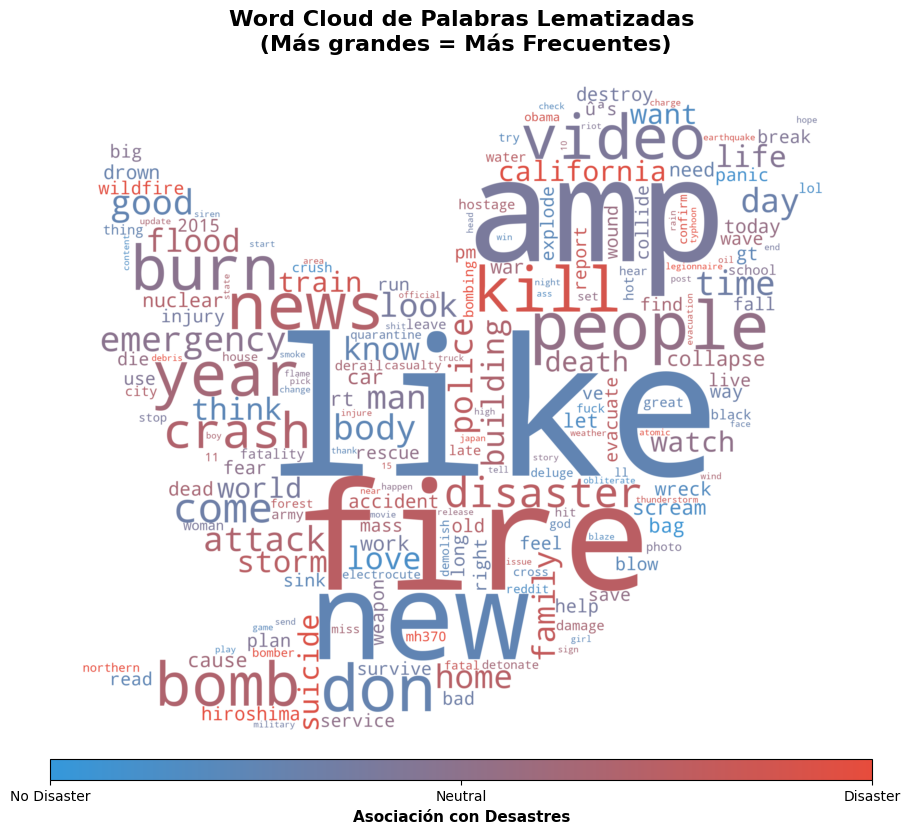

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

twitter_logo = Image.open('twitter.png')
mask = np.array(twitter_logo.convert('L'))

cmap = LinearSegmentedColormap.from_list(
    'disaster_cmap', [COLOR_NO_DISASTER, COLOR_DISASTER]
)
norm = Normalize(vmin=0.0, vmax=1.0)

rates = dict(zip(word_stats['word'].array, word_stats['disaster_rate'].array))

def rate_to_rgb(rate: float) -> str:
    r, g, b, _ = cmap(norm(rate))
    return f"rgb({int(r*255)},{int(g*255)},{int(b*255)})"

# Precompute the exact color for each word once
color_cache = {w: rate_to_rgb(r) for w, r in rates.items()}

def color_func(word, *args, **kwargs):
    return color_cache.get(word, COLOR_GENERAL)

word_freq = dict(zip(word_stats['word'].array, word_stats['total_count'].array))

word_cloud = WordCloud(
    mask=mask,
    background_color='white',
    color_func=color_func,
    max_words=200,
    random_state=42,
    relative_scaling=0.5,
    collocations=False
).generate_from_frequencies(word_freq)

# Plot
fig, ax = plt.subplots(figsize=(14, 9))
ax.imshow(word_cloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Word Cloud de Palabras Lematizadas\n (Más grandes = Más Frecuentes)', fontsize=16, fontweight='bold', pad=20)

# Colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.02, aspect=40, shrink=0.6)
cbar.set_label('Asociación con Desastres', fontsize=11, fontweight='bold')
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['No Disaster', 'Neutral', 'Disaster'])

plt.tight_layout()
plt.show()